<a href="https://colab.research.google.com/github/brandonjchun/chronicabsenteeism/blob/main/ChronicAbsenteeism_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 2017-2018 October 1 Public Enrollment File UPDATED 2021 V2.xlsx to 2017-2018 October 1 Public Enrollment File UPDATED 2021 V2.xlsx
Saving 2018Attendance.xlsx to 2018Attendance.xlsx
Saving chrabs1718.txt to chrabs1718.txt
Saving ChronicallyAbsentRates.xlsx to ChronicallyAbsentRates.xlsx
Saving Cohort 2018 Four Year_Redacted.xls to Cohort 2018 Four Year_Redacted.xls
Saving cohort1718.txt to cohort1718.txt
Saving Dropout Rate 2018 Formatted.xls to Dropout Rate 2018 Formatted.xls
Saving GraduationRatesStudentGroup2018.xlsx to GraduationRatesStudentGroup2018.xlsx
Saving HighSchoolCohort2018.xlsx to HighSchoolCohort2018.xlsx
Saving oregon_cohortmediafile2017-2018.xlsx to oregon_cohortmediafile2017-2018.xlsx
Saving oregon_dropouttables2017-2018.xlsx to oregon_dropouttables2017-2018.xlsx
Saving oregon_regularattenders_report_1718.xlsx to oregon_regularattenders_report_1718.xlsx
Saving ReportCardDataNotes.xlsx to ReportCardDataNotes.xlsx
Saving wash2018Truancy9to12Suppressed.xlsx to wash

**Author**:  Brandon Chun

**Date**:    5/21/2022

**Version**: 1.0

**Purpose**: Using government data regarding absenteeism, graduation rates, and college-enrollment rates, analyzed these statistics for the 2017-2018 school year and created an association between increased public high  school absenteeism and decreased graduation rates using simple linear  regression, which consequently also affects college-enrollment rates  and multiple linear regression that consists of a model with a multiple  R-squared of >0.6 (hopefully).

**Updated:** Using government data regarding absenteeism and graduation rates from  highschools districts across the west coast (California, Oregon,  Washington), created a multi-output regression that predicts graduation  rate, and dropout rate utilizing the singular predictor  of absenteeism. This model was tested with high school districts across  the United States and works with __% accuracy.

**Maybe:** Explored if there exists notable differences in the absentee 
rates in ethnic groups, and socioeconomically disadvantages students

In [ ]:
import numpy as np
import pandas as pd

from pandas import ExcelWriter
from pandas import ExcelFile
from numpy import mean
from numpy import std

import math

#2D Density plot
import seaborn as sns

#simple linear regression for statsmodels ols
import statsmodels

#linear regression
import sklearn
from sklearn import metrics
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
from scipy.special import expit

#multiple linear regression
from sklearn import linear_model


# mlp for multi-output regression
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense

#neural network (keras)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy
from tensorflow.keras.optimizers import Adam
import keras
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import History 

#For Negative Binomial Regression
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

#**Data Cleaning for West Coast State Government Data**

**i) California School District**

In [ ]:
#reading in california school dis
absents = pd.read_csv("chrabs1718.txt", sep = "\t", error_bad_lines=False)
cohort = pd.read_csv("cohort1718.txt", sep = "\t", error_bad_lines=False)

#highschool school absents
hsa = absents[absents["ReportingCategory"] == "GR912"]

#non-charter high school absents (public schools)
nchsa = hsa[hsa["CharterYN"] == "No "]

#aggregated data based on county 
district = nchsa[nchsa["AggregateLevel"] == "D"]

#drop superfluous columns (given we already have filtered for the information)
district_data = district.drop(["AcademicYear", "AggregateLevel", "CountyCode", "SchoolCode", "CountyName", "SchoolName", "CharterYN", "ReportingCategory"], axis= 1)

#rename columns for space and readability. CA = Chronic Absenteeism
district_data = district_data.rename(columns={"DistrictCode": "Code", "DistrictName":"District", "CumulativeEnrollment":"Enrolled", "ChronicAbsenteeismEligibleCumulativeEnrollment":"CA Eligible","ChronicAbsenteeismCount":"CA Count", "ChronicAbsenteeismRate":"CA Rate"})

#filter for district level, non-charter
cohort_filtered = cohort[(cohort["AggregateLevel"] == "D") & (cohort["CharterSchool"] == "No ") & (cohort["ReportingCategory"] == "TA") & (cohort["DASS"] == "All")]

pd.set_option("max_columns", 40)

cohort_data = cohort_filtered.drop(["AcademicYear", "AggregateLevel", "CountyCode", "SchoolCode", "CountyName", "SchoolName", "CharterSchool", "DASS", "ReportingCategory"], axis= 1)
cohort_data = cohort_data.rename(columns={"DistrictCode": "Code", "DistrictName":"District"})


#table based on absentee and graduation rates by county
con = pd.merge(district_data, cohort_data, on="Code", how='inner')

#some manipulation for readability and dropping superfluous columns
con = con.drop("District_y", axis = 1)
con = con.rename(columns = {"District_x":"District"})
con = con.drop(["Enrolled", "CA Eligible", "CA Count"], axis = 1)
con = con.drop(["Code", "Seal of Biliteracy (Count)", "Seal of Biliteracy (Rate)", "Golden State Seal Merit Diploma (Count)", "Golden State Seal Merit Diploma (Rate", "CHSPE Completer (Count)", "CHSPE Completer (Rate)", "Adult Ed. HS Diploma (Count)", "Adult Ed. HS Diploma (Rate)", "SPED Certificate (Count)", "SPED Certificate (Rate)", "GED Completer (Count)", "GED Completer (Rate)", "Other Transfer (Count)", "Other Transfer (Rate)"],  axis = 1)

#Might delete this part later. Taking out the total counts just to get the rates only
con = con.drop(["Regular HS Diploma Graduates (Count)", "Met UC/CSU Grad Req's (Count)", "Dropout (Count)", "Still Enrolled (Count)"], axis = 1)

#Switch column order of cohort students and CA rate for readability
cols = list(con.columns)
a, b = cols.index("CA Rate"), cols.index("CohortStudents")
cols[b], cols[a] = cols[a], cols[b]
con = con[cols]

#filter for "N/A" values
california_con = con[con.CohortStudents != "*"].drop(["Met UC/CSU Grad Req's (Rate)", "Still Enrolled (Rate)"], axis= 1)




/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


**i) Oregon School District**

In [ ]:
oc = pd.read_excel("oregon_cohortmediafile2017-2018.xlsx")
oa = pd.read_excel("oregon_regularattenders_report_1718.xlsx", 'Data')
od = pd.read_excel("oregon_dropouttables2017-2018.xlsx", 'School and District')

oc_filtered = oc[(oc["Student Group"] == "All Students") & (oc["Institution Level"] == "District")].drop(["Unnamed: 7", "Unnamed: 8", "Unnamed: 9", "Unnamed: 10", "Four-year Cohort Completer Rate", "Unnamed: 12", "Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "School ID", "School Name", "Student Group Code", "Student Group", "Institution Level", "Notes"], axis = 1)
oa_filtered = oa[(oa["Student Group"] == "All Students") & (oa["Institution Type"] == "District")] .drop(["Institution ID", "Institution", "Institution Type", "Student Group", "Regular Attenders Number", "Chronically Absent Number"], axis = 1)
od_filtered = od[(od["Student Group"] == "All Students") & (od["Institution Type"] == "District")].drop(["School Year", "County", "Resident District Name", "Resident School ID", "Resident School Name", "Student Group Code", "Student Group", "Institution Type", "Fall \nMembership", "ADM \nEnrollment", "Dropout Count"], axis = 1).rename(columns = {"Resident District ID":"District ID"})

oregon_con_temp = pd.merge(oc_filtered, oa_filtered, on="District ID", how='inner').drop(["District"], axis = 1)

oregon_merged = pd.merge(oregon_con_temp, od_filtered, on = "District ID", how = "inner").drop(["District ID", "Regular Attenders Percent"], axis = 1)
oregon_con = oregon_merged[(oregon_merged["Four-year Cohort Graduation Rate"] != "--") & (oregon_merged["Students Included"] != "*")].replace("<5", 2.5)


**i) Washington School District**

In [ ]:
wca = pd.read_excel("wash2018Truancy9to12Suppressed.xlsx")
wcg = pd.read_csv("washReport_Card_Graduation_2017-18.csv")

wca.columns = wca.iloc[1]
wca1 = wca.drop([0, 1, 313, 314, 315, 316])
wca2 = wca1[wca1["District Name"] != "  All"].drop(["School Year", "County", "Enrollment", "Unexcused Absences", "Students with 1 or more Unexcused Absence", "Percent of Students with 1 or more Unexcused Absences", "5+ Absences in a Month", "Percent of Students with Five or More Unexcused Absences in a Month", "10+ Absences in the School Year", "Truant", "Filed Truancy Petition", "Percent of Students with a Filed Truancy Petition"], axis = 1).rename(columns = {"Percent of Students with Ten or More Unexcused Absences in a Year":"CA Rate"})

wca3 = wca2[wca2["CA Rate"]!= "Suppressed"]

wcg1 = wcg[(wcg["OrganizationLevel"] == "District") & (wcg["StudentGroupType"] == "All") & (wcg["Cohort"] == "Four Year")].drop(["SchoolYear", "County", "ESDName", "ESDOrganizationId", "OrganizationLevel", "DistrictCode", "DistrictOrganizationId", "SchoolCode", "SchoolName", "SchoolOrganizationId", "StudentGroupType", "StudentGroup", "Suppression", "BegginingGrade9", "TransferIn", "Year1Dropout", "Year2Dropout", "Year3Dropout", "Year4Dropout", "Year5Dropout", "Year6Dropout", "Year7Dropout", "TransferOut", "DataAsOf"], axis= 1).dropna()

wcg1["DropoutRate"] = wcg1.Dropout / wcg1.FinalCohort

wcg2 = wcg1.drop(["Cohort", "Graduate", "Continuing", "Dropout"], axis = 1).rename(columns = {"DistrictName":"District Name"})
        
washington_con = pd.merge(wca3, wcg2, on="District Name", how = "inner")



**Merging Data From Cleaned West Coast State Government Data**

In [ ]:
california_con = california_con.rename(columns = {"CohortStudents":"Cohort", "Regular HS Diploma Graduates (Rate)":"GraduationRate", "Dropout (Rate)":"DropoutRate", "CA Rate":"CARate"})
oregon_con = oregon_con.rename(columns = {"District Name":"District", "Four-year Cohort Graduation Rate":"GraduationRate", "Students Included":"Cohort", "Chronically Absent %":"CARate", "Graduation Rate":"GraduationRate", "Dropout Rate":"DropoutRate"})
washington_con = washington_con.rename(columns = {"District Name":"District", "FinalCohort":"Cohort", "GraduationRate":"GraduationRate", "DropoutRate":"DropoutRate", "CA Rate":"CARate"})

washington_con["CARate"] = washington_con["CARate"].apply(lambda x: x * 100.0)
washington_con["GraduationRate"] = washington_con["GraduationRate"].apply(lambda x: x * 100.0)
washington_con["DropoutRate"] = washington_con["DropoutRate"].apply(lambda x: x * 100.0)


#concatenate all the data to create a table of westcoast high schools with cohort, chronic absenteeism rate, graduation rate, dropout rate
data = pd.concat([california_con, oregon_con, washington_con], ignore_index = True, sort = False)

#sort the table by increasing CA rate to gain intuition for the graduation data
data["CARate"] = data["CARate"].astype(float)
data_assorted = data.sort_values(by = "CARate", ascending = False).reset_index().drop("index", axis = 1)

#turn data points to float
data["CARate"] = data["CARate"].astype(float)
data["GraduationRate"] = data["GraduationRate"].astype(float)
data["DropoutRate"] = data["DropoutRate"].astype(float)

In [ ]:
display(data)

,District,Cohort,CARate,GraduationRate,DropoutRate
0,Alameda County Office of Education,188,55.1,35.60,52.100000
1,California School for the Deaf-Fremont (State ...,38,11.4,65.80,2.600000
2,Alameda Unified,806,12.9,93.20,2.700000
3,Albany City Unified,290,7.6,92.40,3.100000
4,Berkeley Unified,833,11.2,85.70,11.200000
...,...,...,...,...,...
765,Sunnyside School District,466.0,29.7,90.13,9.442060
766,Toppenish School District,275.0,10.4,80.00,13.454545
767,Wapato School District,230.0,34.0,80.00,14.782609
768,Yakima School District,1076.0,38.9,79.46,14.219331


**Acquiring Test Data (Validation Set)**

Acknowledgement: The data from the Utah School Districts were documented differently compared to the three states the training data was based on (California, Washington, Oregon). The difference referred to is that the latter schools calculated Chronic Absenteeism in high school students (Grade 9-12), while Utah calculates Chronic Absenteeism rates including all students (K-12). Hence, the actual data being compared may not be directly proportional, but the hope is that with this large of a dataset, some of those differences may average out to allow for a useful result regardless.

In [ ]:
uc = pd.read_excel("HighSchoolCohort2018.xlsx", 'County')
ua = pd.read_excel("ChronicallyAbsentRates.xlsx", "By County")
ud = pd.read_excel("HighSchoolCohort2018.xlsx", 'County')

utah_con_temp = pd.merge(uc, ud, on="County Name", how='inner')
utah_con = pd.merge(utah_con_temp, ua, left_on="County Name", right_on="County", how="inner")
utah_merged = utah_con[["County Name", "Group Cohort Grad Rate Masked_x", "Group Cohort Dropout Rate Masked_x", "SY 2018 K-12 Chronically Absent (CA) Rate"]]
mapping = {">= 80%" : .90, "< 20%" : .10, ">= 90%" : .95,  "< 10%" : .05, "≤5%" : .025, "**" : .025}

utah_merged = utah_merged.rename(columns={"County Name":"County", "Group Cohort Grad Rate Masked_x":"GraduationRate", "Group Cohort Dropout Rate Masked_x":"DropoutRate", "SY 2018 K-12 Chronically Absent (CA) Rate":"CARate"}).replace(mapping)

display(utah_merged)

,County,GraduationRate,DropoutRate,CARate
0,Beaver,0.829,0.147,0.075
1,Box Elder,0.841,0.140,0.153
2,Cache,0.922,0.059,0.025
3,Carbon,0.948,0.024,0.323
4,Daggett,0.900,0.100,0.152
5,Davis,0.948,0.029,0.107
6,Duchesne,0.879,0.107,0.202
7,Emery,0.938,0.063,0.230
8,Garfield,0.931,0.056,0.211
9,Grand,0.826,0.119,0.112


In [ ]:
X_test = utah_merged["GraduationRate"].to_numpy().reshape (-1,1)

keys = np.arange(29)
i, y_test = 0, []
for i in keys:
    y_test.append([utah_merged["CARate"][i], utah_merged["DropoutRate"][i]])
    
    
y_test = np.array(y_test)
#display(X_test)
#display(y_test)

#print(np.shape(X_test))
#print(np.shape(y_test))

#**Visualizing the Data**

Initially created scatterplots of:  

*   Chronic Absenteeism vs Graduation 
*   Chronic Absenteeism vs Dropout

Due to highly dense portions of the graph, opted to redisplay data using 2D Density Plots with Seaborn to portray areas where data may be heavily centered.

**i) Chronic Absenteeism vs Graduation Rate**

Text(0, 0.5, 'Graduation Rate')

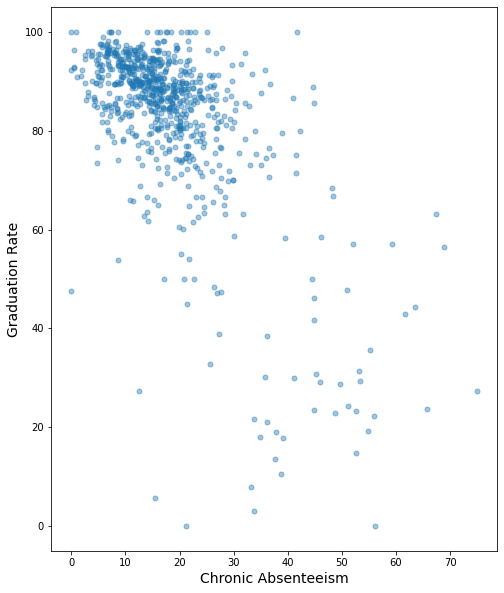

In [ ]:
plt.figure(figsize=(8, 10))
plt.scatter(data["CARate"], data["GraduationRate"], marker='o', s=25, alpha=0.425)
plt.xlabel("Chronic Absenteeism", fontsize=14)
plt.ylabel("Graduation Rate", fontsize=14)

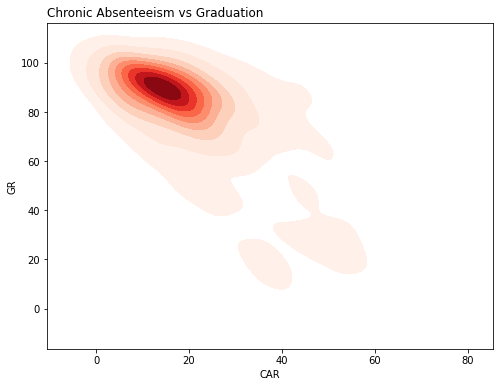

In [ ]:
df = pd.DataFrame()
df["CAR"] = data["CARate"]
df["GR"] = data["GraduationRate"]

plt.figure(figsize=(8, 6))
sns.kdeplot(data = df, x="CAR", y="GR", cmap="Reds", shade=True)
plt.title('Chronic Absenteeism vs Graduation', loc='left')
plt.show()

In [ ]:
#df = pd.DataFrame()
#df["CAR"] = data["CARate"]
#df["GR"] = data["GraduationRate"]
#cvs = ds.Canvas(plot_width=50, plot_height=50)  # auto range or provide the `bounds` argument
#agg = cvs.points(df, 'CAR', 'GR')  # this is the histogram
#img = ds.tf.set_background(ds.tf.shade(agg, how="log", cmap=cc.fire), "black").to_pil()  # create a rasterized image

#plt.imshow(img)
#plt.axis("off")
#plt.show()

**ii) Dropout Rate vs Graduation Rate**

Text(0, 0.5, 'Graduation Rate')

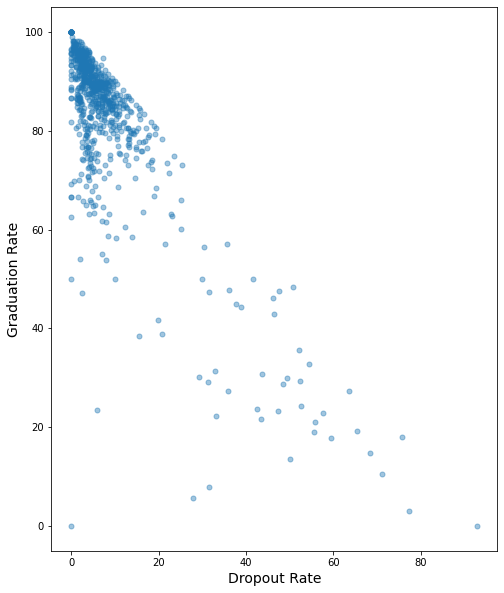

In [ ]:
plt.figure(figsize=(8, 10))
plt.scatter(data["DropoutRate"], data["GraduationRate"], marker='o', s=25, alpha=0.425)
plt.xlabel("Dropout Rate", fontsize=14)
plt.ylabel("Graduation Rate", fontsize=14)

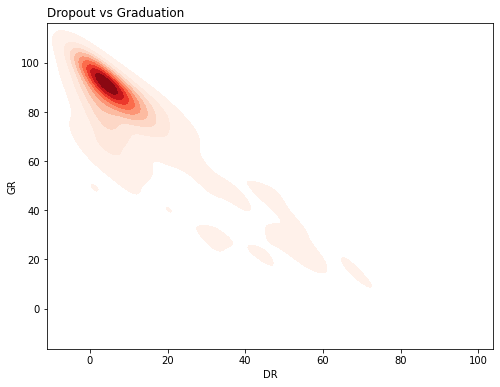

In [ ]:
df = pd.DataFrame()
df["DR"] = data["DropoutRate"]
df["GR"] = data["GraduationRate"]

plt.figure(figsize=(8, 6))
sns.kdeplot(data = df, x="DR", y="GR", cmap="Reds", shade=True)
plt.title('Dropout vs Graduation', loc='left')
plt.show()

From looking at the above graphs, we can see that there seems to be an inverse relationship

#**StatsModels Ordinary Least Squares Regression**

**i) Regression on CA Rate vs Grad Rate**

"Manually" calculated OLS Regression --> Used values such as respective means, covariance, and variance to find the beta variable and the constant value.

In [ ]:
ymean_gca = np.mean(data["GraduationRate"])
xmean_gca = np.mean(data["CARate"])

beta_gca = ((data["CARate"] - xmean_gca) * (data["GraduationRate"] - ymean_gca)).sum() / ((data["CARate"] - xmean_gca)**2).sum()
alpha_gca = ymean_gca - (beta_gca * xmean_gca)
print(alpha_gca, beta_gca)

100.7380034163011 -0.979321832326759


Text(0, 0.5, 'Graduation Rate')

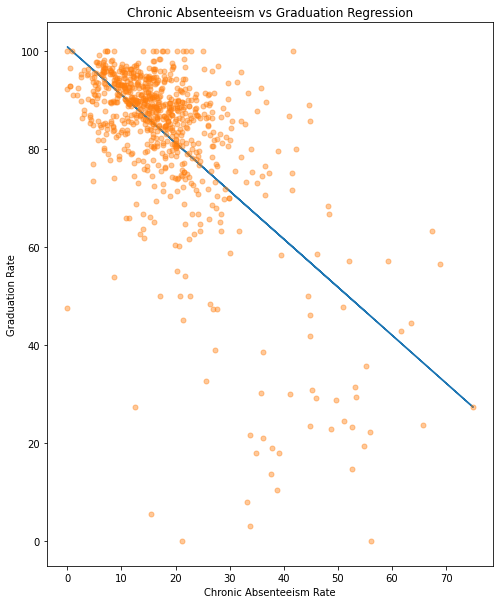

In [ ]:
ypred_gca = alpha_gca + beta_gca * data["CARate"]

plt.figure(figsize=(8, 10))
plt.plot(data["CARate"], ypred_gca)
plt.plot(data["CARate"], data["GraduationRate"], 'o', markersize=5, alpha = 0.425)
plt.title("Chronic Absenteeism vs Graduation Regression")
plt.xlabel("Chronic Absenteeism Rate")
plt.ylabel("Graduation Rate")
#plt.hlines(100, 0, 75)

In [ ]:
y_pred = [beta_gca * x + alpha_gca for x in data["CARate"]]
print(np.sqrt(metrics.mean_squared_error(data["GraduationRate"], y_pred)))

12.745257463432235


**ii) Regression on Dropout Rate vs Grad Rate**

For this regression, used built-in functions of statsmodels instead of manually computing the beta and alpha for the model. 

In [ ]:
#find an initial fit for the model
ols_y_gdr = data["GraduationRate"]
ols_x_gdr = data["DropoutRate"]
ols_x_gdr = sm.add_constant(ols_x_gdr)
model = sm.OLS(ols_y_gdr, ols_x_gdr)
results = model.fit()
results.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const          92.694082
DropoutRate    -1.206120
dtype: float64

Text(0, 0.5, 'Graduation Rate')

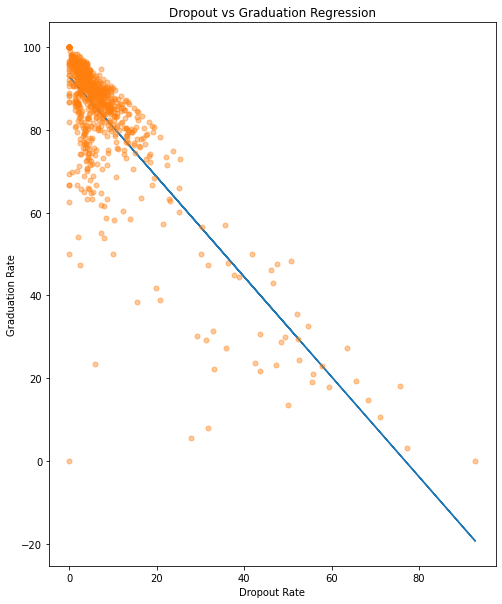

In [ ]:
alpha_gdr = results.params[0]
beta_gdr = results.params[1]

ypred_gdr = alpha_gdr + beta_gdr * data["DropoutRate"]

plt.figure(figsize=(8, 10))
plt.plot(data["DropoutRate"], ypred_gdr)
plt.plot(data["DropoutRate"], data["GraduationRate"], 'o', markersize=5, alpha = 0.425)
plt.title("Dropout vs Graduation Regression")
plt.xlabel("Dropout Rate")
plt.ylabel("Graduation Rate")
#plt.hlines(100, 0, 75)

In [ ]:
y_pred = [beta_gdr * x + alpha_gdr for x in data["DropoutRate"]]
print(np.sqrt(metrics.mean_squared_error(data["GraduationRate"], y_pred)))

9.609135554845382


Analysis: Although the prediction lines generally follow the trend of the data, the OLS Regression does not seem to properly explain a majority of the data. This discrepancy can be attributed to the fact that the initial dataset is clustered near the extremities, and such data is not advisable for linear regression because of the high variability within extremely low changes in either variable. Specifically, the RMSE for each regression, respectively, returns $12.7$ and $9.6$, where as RMSE values should generally return between $0.2$ and $0.5$

#**Multiple Linear Regression**

Now that we have taken a look at ordinary least squares, simple linear regression, now let's take a look into multiple linear regression. This means that we will take into account both dependent variables (Chronic Absenteeism Rate and Dropout Rate) as predictors for the overall Graduation Rate, instead of analyzing their separate, individual effects on the Graduation Rate. 

First we will visualize the dataset in a 3D space.

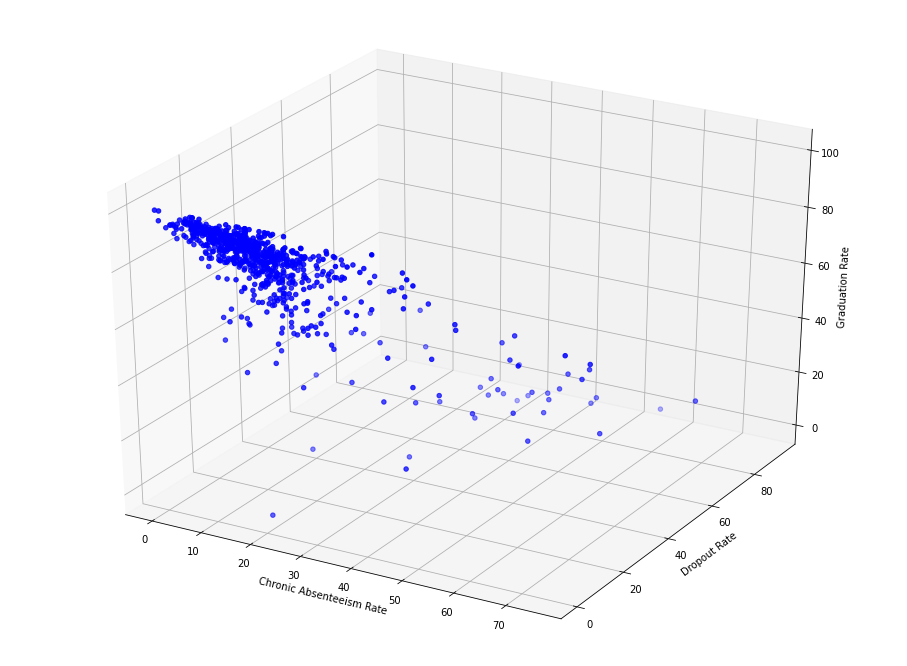

In [ ]:
CAR = data["CARate"]
DR = data["DropoutRate"]
GR = data["GraduationRate"]

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(CAR, DR, GR, c="blue", marker="o")

# set your labels
ax.set_xlabel('Chronic Absenteeism Rate')
ax.set_ylabel('Dropout Rate')
ax.set_zlabel('Graduation Rate')

plt.show()

In [ ]:
X_mlr = data[["CARate", "DropoutRate"]]
y_mlr = data["GraduationRate"]


#display(X_mlr.values)
#display(y_mlr.values)

mlr = linear_model.LinearRegression()
mlr.fit(X_mlr.values, y_mlr.values)

display(mlr.coef_)
display(mlr.intercept_)

array([-0.39307423, -0.99146835])

98.06293618470187

The coefficients tell us that in respect to the graduation rate, if the Chronic Absenteeism rate increases by 1%, the Graduation rate increases/decreases by -0.39%. Likewise, if the Dropout rate increases by 1%, the Graduation rate increases/decreases by -0.99%.

In [ ]:
lst = []

#for x in data["CARate"]:
#  for y in data["DropoutRate"]:
#    lst.append(mlr.predict([x, y]))

pred_mlr = [mlr.predict(np.array([x, y]).reshape(1, -1)) for x, y in zip(data["CARate"], data["DropoutRate"])]

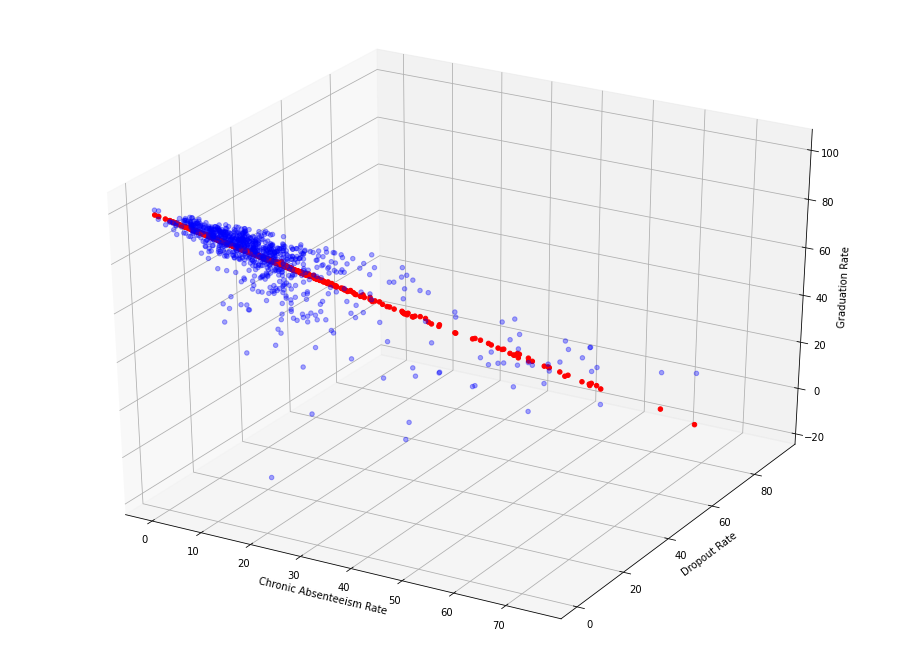

In [ ]:
CAR = data["CARate"]
DR = data["DropoutRate"]
GR = data["GraduationRate"]
GR_pred = pred_mlr

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(CAR, DR, GR_pred, c="red", marker="o", alpha = 1)
ax.scatter(CAR, DR, GR, c="blue", marker="o", alpha = .35)


# set your labels
ax.set_xlabel('Chronic Absenteeism Rate')
ax.set_ylabel('Dropout Rate')
ax.set_zlabel('Graduation Rate')

plt.show()

In [ ]:
print(np.sqrt(metrics.mean_squared_error(data["GraduationRate"], pred_mlr)))

8.968318677623245


Just like the OLS Regression examples, adding a feature in and applying multiple linear regression does not seem to solve the issue of highly dense data for a linear model. The RMSE remains relatively high at a value of $8.968$, which is in theory better than our OLS Regressions, but regardless is an absurdly high value that indicates our model holds no statistical significance.


#**Conclusions on Linear Regression**

 It could be possible that adding more features could help the model by


1.   Splitting the data into more concrecte distributions (lowering density and making the pattern easier to discern)
2.   Allowing multiple linear regression to properly value the strengths of each feature, rather than distributing the weights among just two features

However, due to the lack of availability for these features consistently across different databases, I will opt to leave these ideas as an exercise. To be frank, I think this would allow for a substantially better model, and would be effective enough to draw some firm conclusions on the relationship we are exploring.





#**Neural Networks**

Now that linear regression is proven to be a not-so-good model for this dataset, we can move on to different models. The next model we will apply to this dataset is Neural Networks (yay!)

**Preparing Data**

To make the data easier to use, we will extract the data into usable forms from the cleaned data table created above.

In [ ]:
X = data["GraduationRate"].to_numpy().reshape (-1,1)

keys = np.arange(770)
i, y, y_norm = 0, [], []
c = data["CARate"]
d = data["DropoutRate"]
cm1 = np.mean(data["CARate"])
cs1 = np.std(data["CARate"])
dm2 = np.mean(data["DropoutRate"])
ds2 = np.std(data["DropoutRate"])

for i in keys:
    y.append([data["CARate"][i], data["DropoutRate"][i]])
    y_norm.append([(c[i] - cm1)/cs1, (d[i] - dm2)/ds2])
    
y = np.array(y)
y_norm = np.array(y_norm)
#display(X)
#display(y)

def norm(d):
  return (d - np.mean(d)) /np.std(d)

X_norm = norm(X)

print(y_norm)

###Check for y_norm being standardized correctly later

#sum_c = 0
#for i in y_norm:
#  sum += i[0]


c = utah_merged["CARate"]
d = utah_merged["DropoutRate"]
cm1 = np.mean(utah_merged["CARate"])
cs1 = np.std(utah_merged["CARate"])
dm2 = np.mean(utah_merged["DropoutRate"])
ds2 = np.std(utah_merged["DropoutRate"])

keys = np.arange(29)
i, y_test, y_test_norm = 0, [], []
for i in keys:
    y_test_norm.append([(c[i] - cm1)/cs1, (d[i] - dm2)/ds2])
    
    
y_test_norm = np.array(y_test)

X_test_norm = norm(X_test)


print(type(X_norm))
print(type(y_norm))
print(type(X_test_norm))
print(type(y_test_norm))

#print(np.shape(X_test))
#print(np.shape(y_test))

[[ 3.47825882  3.97806532]
 [-0.6183436  -0.48133318]
 [-0.47772795 -0.4723243 ]
 ...
 [ 1.50026543  0.61618413]
 [ 1.95960987  0.56543907]
 [-1.2464268   0.41054652]]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


**Neural Networks using Keras (nonlinear regression)**

In [ ]:
# Create model
model = Sequential()
model.add(Dense(4, activation="relu", input_dim=2))
model.add(Dense(2, activation="relu"))
# Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
# Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.
model.add(Dense(1, activation="linear"))

# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-3, decay=1e-3 / 200))

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Fit the model-
history = model.fit(X_norm, y_norm, validation_data=(X_test_norm, y_test_norm), epochs=200, batch_size=4, verbose=0, callbacks=[es])

# Calculate predictions
PredTestSet = model.predict(X_norm)
PredValSet = model.predict(X_test_norm)

print("boo tomato tomato")
display(PredTestSet)
print("boo tomato tomato")
display(PredValSet)
print("boo tomato tomato")

# Save predictions
#numpy.savetxt("trainresults.csv", PredTestSet, delimiter=",")
#numpy.savetxt("valresults.csv", PredValSet, delimiter=",")

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

ValueError: ignored

**Neural Network using ReLUs (nonlinear)**

In [ ]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model

def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        print(len(train_ix), len(test_ix))
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100)
        # evaluate model on test set
        mae = model.evaluate(X_test, y_test, verbose=0)
        # store result
        print('>%.3f' % mae)
        results.append(mae)
    return results

In [ ]:
test = data["CARate"]
X = data["CARate"].to_numpy()
print(type(X))
X = np.reshape(X, (X.shape[0], 1))

print(type(test))

print(type(X))

results = evaluate_model(X, y)
print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


AttributeError: ignored

In [ ]:
n_inputs, n_outputs = X.shape[1], y.shape[1]
model = get_model(n_inputs, n_outputs)
model.fit(X, y, verbose = 0, epochs = 100)



We've evaluated the neural network model and got a Mean Absolute Error of 0.102. Now we will be testing new data points to see the accuracy of our NN model.

In [ ]:
#concatenate all the data to create a table of westcoast high schools with cohort, chronic absenteeism rate, graduation rate, dropout rate
data = pd.concat([california_con, oregon_con, washington_con], ignore_index = True, sort = False)

#sort the table by increasing CA rate to gain intuition for the graduation data
data["CARate"] = data["CARate"].astype(float)
data_assorted = data.sort_values(by = "CARate", ascending = False).reset_index().drop("index", axis = 1)

#turn data points to float
data["CARate"] = data["CARate"].astype(float)
data["GraduationRate"] = data["GraduationRate"].astype(float)
data["DropoutRate"] = data["DropoutRate"].astype(float)

#turn data points to percentage
data["CARate"] = data["CARate"].apply(lambda x: x / 100.0)
data["GraduationRate"] = data["GraduationRate"].apply(lambda x: x / 100.0)
data["DropoutRate"] = data["DropoutRate"].apply(lambda x: x / 100.0)